In [ ]:
# Install the required libraries
#SAM
#! pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
#! pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
#! pip install datasets
#! pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
#! pip install patchify
#! pip install matplotlib
#! pip install tifffile
#! pip install scipy
#! pip install opencv-python


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import glob
import cv2
from tqdm import tqdm

In [4]:
from huggingface_hub import hf_hub_download

# Download the SAM vit_h checkpoint
checkpoint_path = hf_hub_download(
    repo_id="HCMUE-Research/SAM-vit-h",       # You can also try "facebook/sam-vit-h" if available
    filename="sam_vit_h_4b8939.pth"
)

# Use it with SAM
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint=checkpoint_path)

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

device = "cpu"

sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

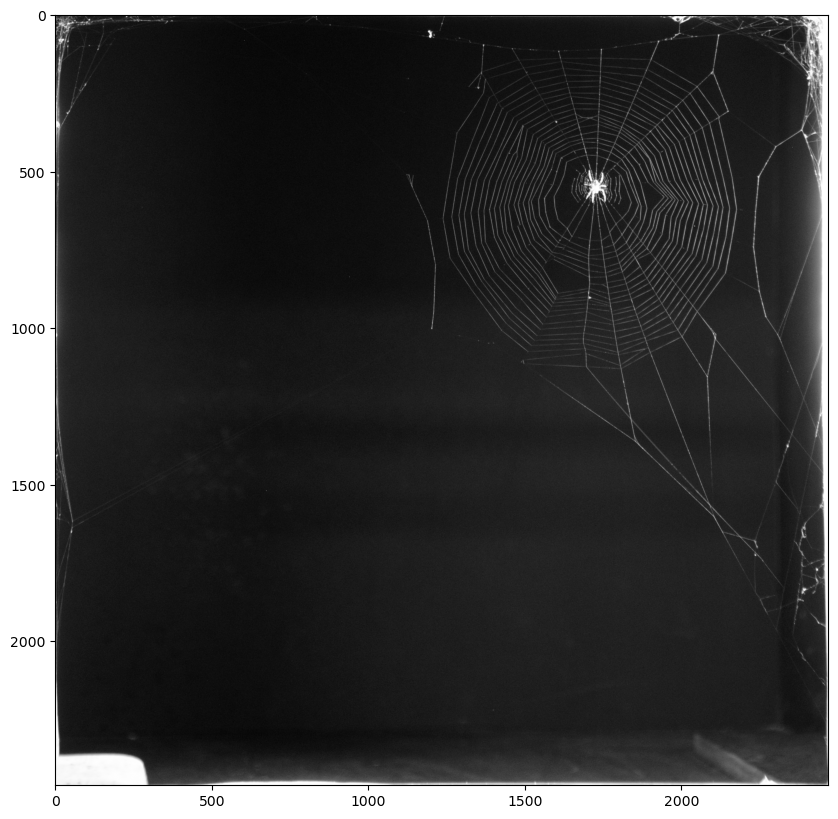

In [7]:
#Work on converting initial mask generation and the generalization of this process to using the cropped forms and SAM or grounded SAM, SAM2, SAM2 Adapter, etc; whatever works
pointImage = cv2.imread(r"C:\Users\adamain\Downloads\cropped_frames\cropped_EX.jpg")
pointImage = cv2.cvtColor(pointImage, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.imshow(pointImage, cmap='gray')
plt.axis('on')
plt.show()

In [8]:
predictor = SamPredictor(sam)

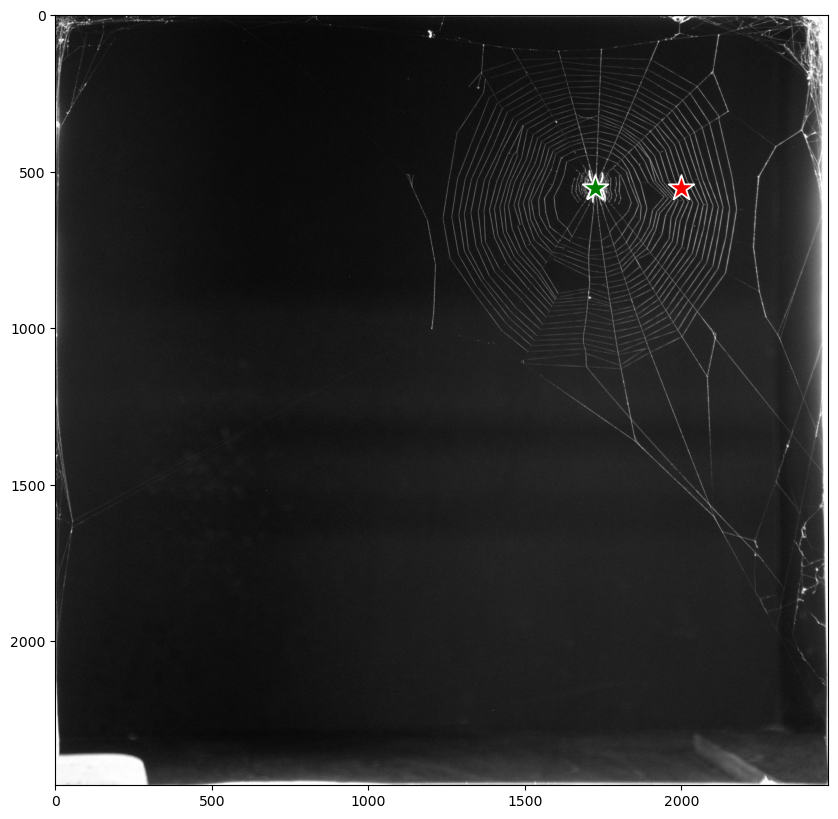

In [9]:
# Positive (foreground) and negative (background) point coordinates
input_point = np.array([[1725, 550], [2000, 550]])  # First point: spider; second: web
input_label = np.array([1, 0])  # 1 = positive, 0 = negative

# Show image with points
plt.figure(figsize=(10,10))
plt.imshow(pointImage, cmap='gray')
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [60]:
def process_image(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(image,180, 255, cv2.THRESH_BINARY)
    rgb_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
    return rgb_thresh

In [62]:
rgb_thresh = process_image(pointImage)
predictor.set_image(rgb_thresh)

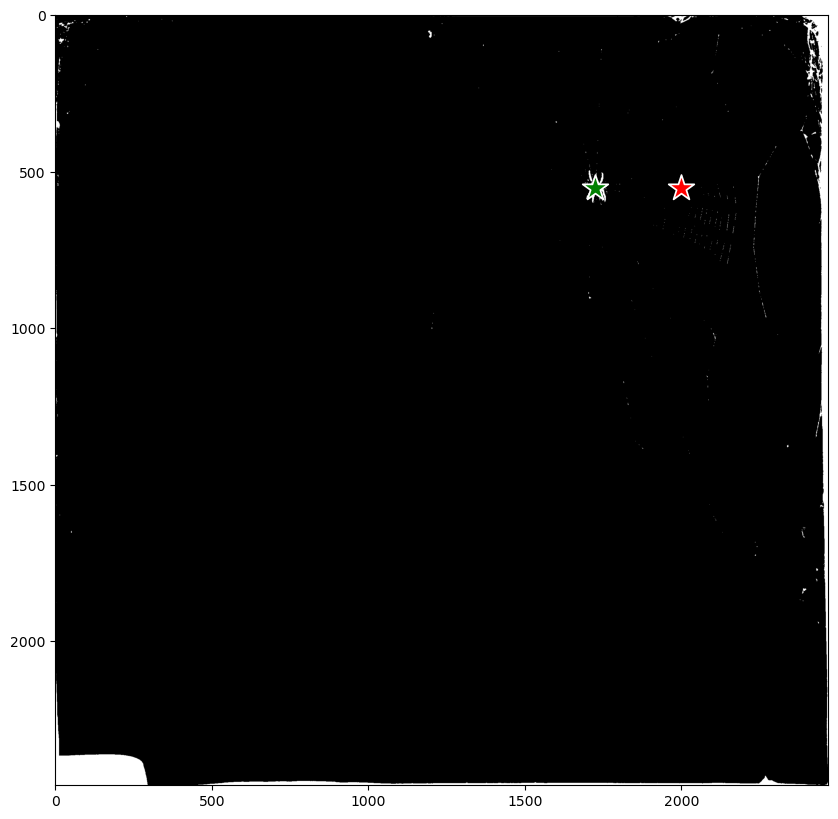

In [63]:
plt.figure(figsize=(10,10))
plt.imshow(rgb_thresh, cmap='gray')
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [64]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

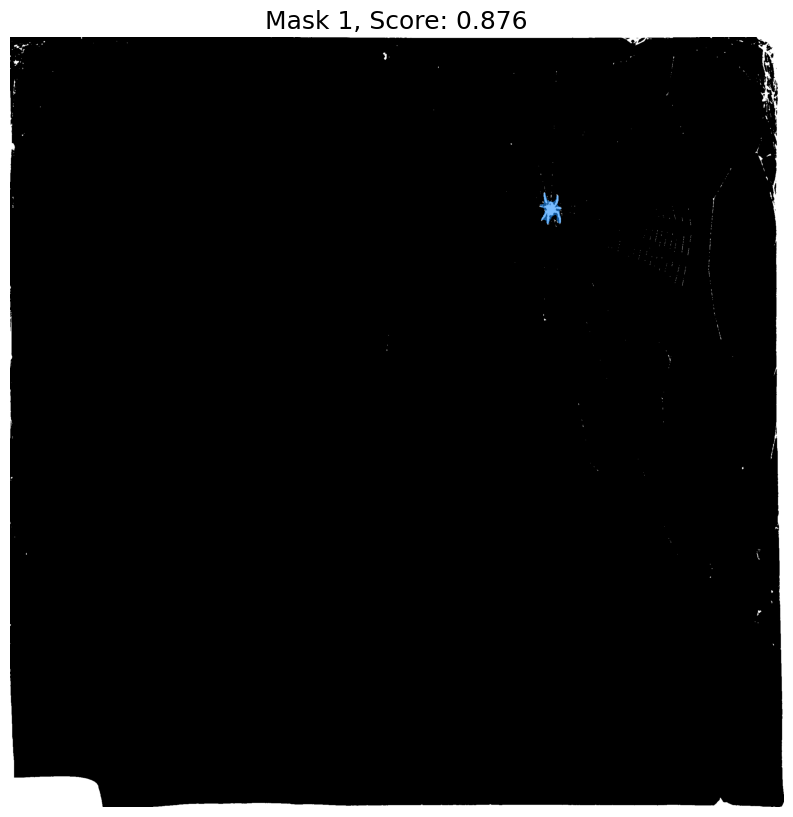

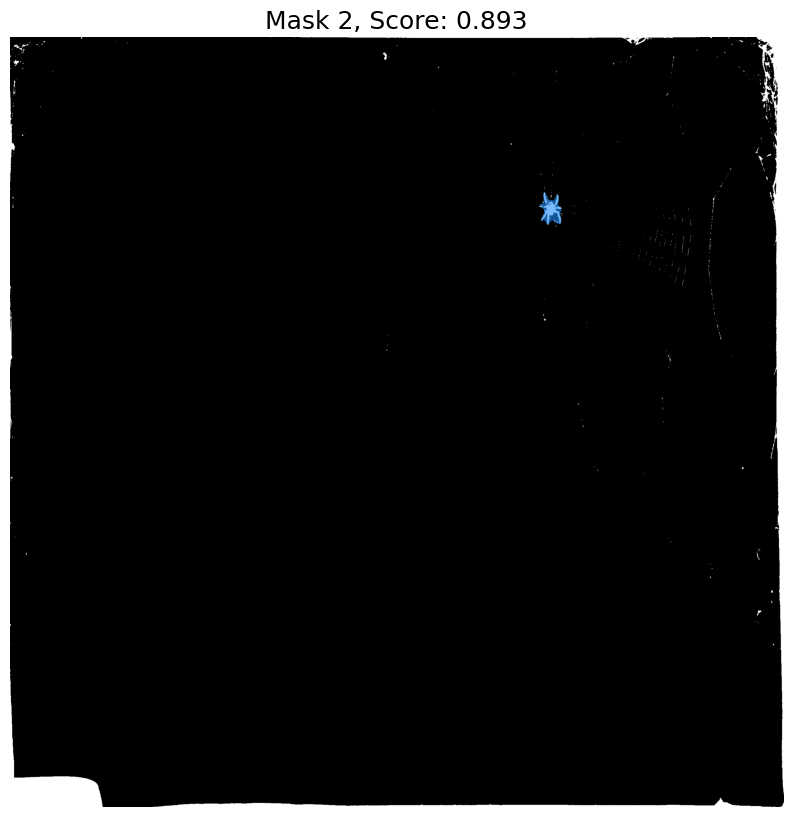

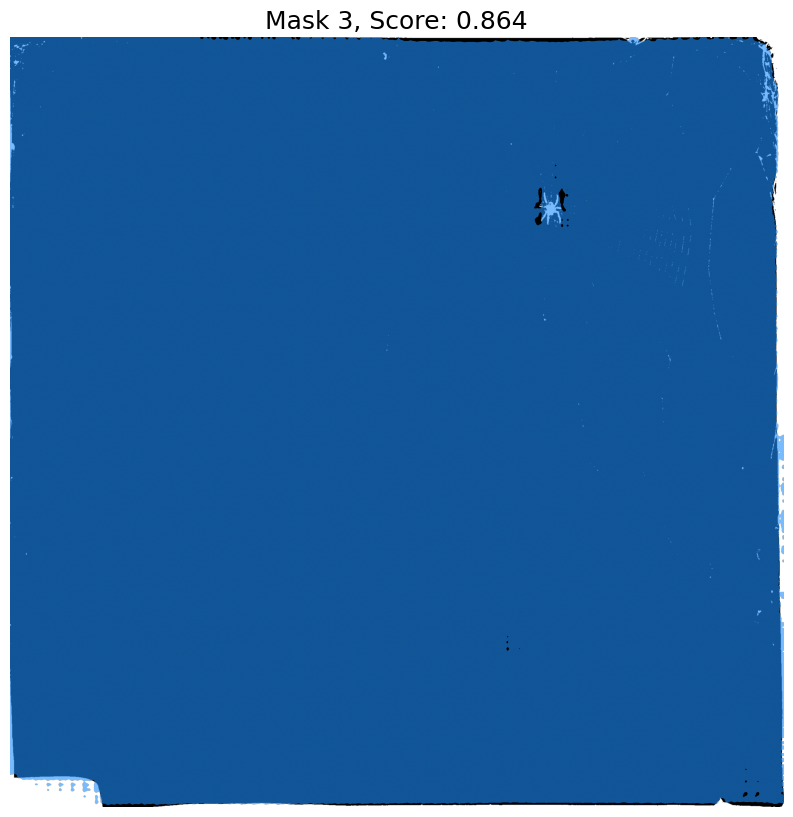

In [65]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(rgb_thresh)
    show_mask(mask, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [54]:
import numpy as np
import torch
import torch.nn.functional as F

# Your input points and labels
input_point = np.array([[2440, 840], [2300, 840]])
input_label = np.array([1, 0])  # 1 = positive (spider), 0 = negative (web)

# SAM's internal feature map is likely lower resolution, so we use the embed coordinates
# predictor.transform works from full-res -> low-res, which is what we need here

# Convert points to torch tensor in (x, y) format
input_point_torch = torch.tensor(input_point, dtype=torch.float)

# Map to embedding coordinates (shape [B, C, h, w])
image_embedding = predictor.features  # shape: [1, C, H', W']
_, C, H_feat, W_feat = image_embedding.shape

# Project the points from original image to embedding resolution using SAM transform
input_point_embed = predictor.transform.apply_coords(input_point, image.shape[:2])  # returns Nx2 in (x, y)
input_point_embed = np.round(input_point_embed).astype(int)

# Clamp points to stay inside feature map bounds
input_point_embed[:, 0] = np.clip(input_point_embed[:, 0], 0, W_feat - 1)
input_point_embed[:, 1] = np.clip(input_point_embed[:, 1], 0, H_feat - 1)

# Extract features at each point
features = []
for x, y in input_point_embed:
    feat = image_embedding[0, :, y, x]  # shape: [C]
    features.append(feat.cpu().numpy())

features = np.stack(features)  # shape: [N_points, C]

# Now, split into positive and negative groups
positive_features = features[input_label == 1]
negative_features = features[input_label == 0]

# For future use: create "centroid" signatures
spider_signature = np.mean(positive_features, axis=0)
web_signature = np.mean(negative_features, axis=0)

# Optional: Normalize for cosine similarity use
spider_signature /= np.linalg.norm(spider_signature)
web_signature /= np.linalg.norm(web_signature)


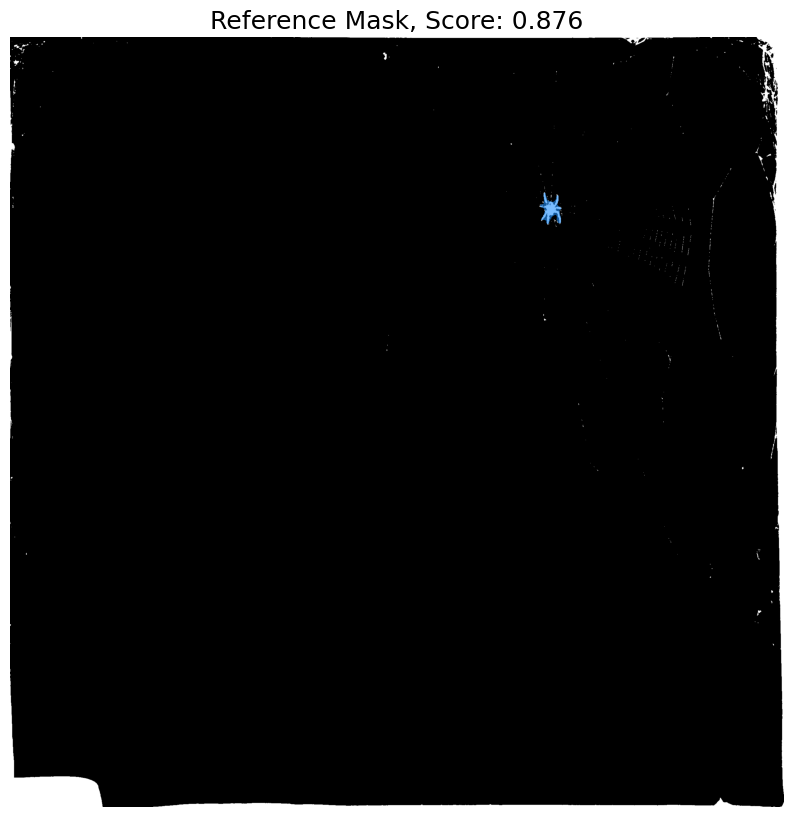

In [66]:
reference = masks[0]
referenceScore = scores[0]
plt.figure(figsize=(10,10))
plt.imshow(rgb_thresh)
show_mask(reference, plt.gca())
plt.title(f"Reference Mask, Score: {referenceScore:.3f}", fontsize=18)
plt.axis('off')
plt.show()  

In [67]:
def crop_to_mask_circle(image, mask, padding=10):
    """
    Crop the image to the smallest enclosing circle around the non-zero region in the mask.

    Parameters:
        image (np.ndarray): Original image (H, W, C)
        mask (np.ndarray): Binary mask (H, W) where non-zero values define the region of interest
        padding (int): Optional padding around the circle (in pixels)

    Returns:
        cropped_image (np.ndarray): Cropped image around the circular region
    """
    # Ensure mask is binary
    mask = (mask > 0).astype(np.uint8)

    # Get coordinates of the non-zero mask area
    points = cv2.findNonZero(mask)
    if points is None:
        return None  # or raise an exception

    # Find the smallest enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(points)

    # Add padding
    x, y, radius = int(x), int(y), int(radius + padding)

    # Compute square bounding box
    x1 = max(x - radius, 0)
    y1 = max(y - radius, 0)
    x2 = min(x + radius, image.shape[1])
    y2 = min(y + radius, image.shape[0])

    # Crop the image
    cropped_image = image[y1:y2, x1:x2]
    cropped_mask = mask[y1:y2, x1:x2]

    return cropped_image, cropped_mask


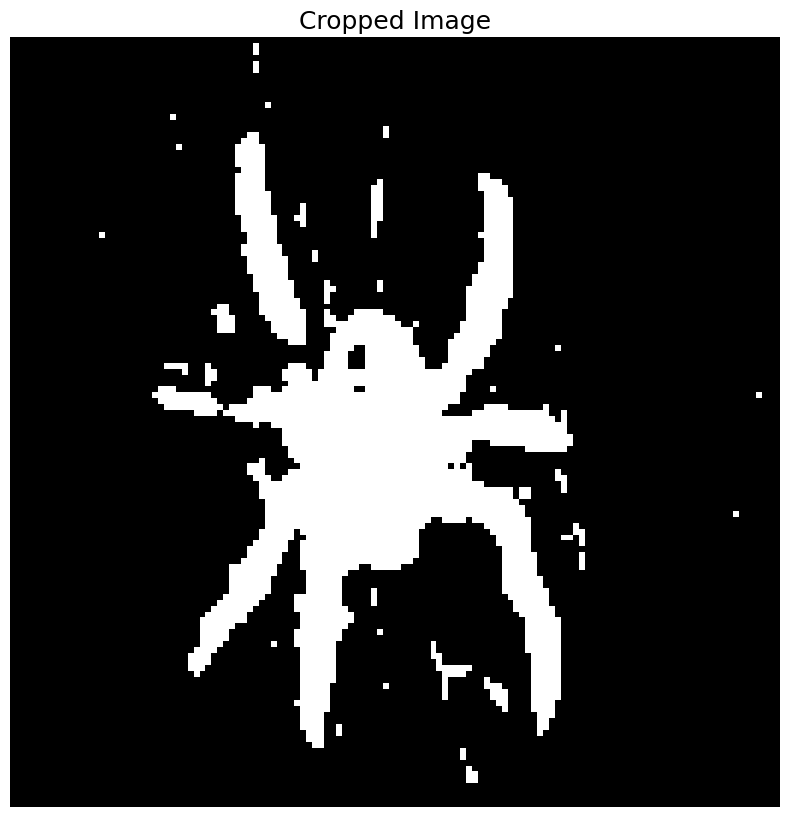

In [70]:
crop, cropMask = crop_to_mask_circle(rgb_thresh, reference)

plt.figure(figsize=(10,10))
plt.imshow(crop)
plt.title(f"Cropped Image", fontsize=18)
plt.axis('off')
plt.show()  

In [363]:
def process_spider(crop):
    if len(crop.shape) == 3:
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))
    closed = cv2.morphologyEx(crop, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    edited = np.zeros_like(closed)  # blank image to draw on

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        aspect_ratio = float(w) / h if h != 0 else 0

        if area > 500 and aspect_ratio < 4:
            cv2.drawContours(edited, [cnt], -1, 255, thickness=cv2.FILLED)   

    edited = cv2.GaussianBlur(edited, (3, 3), 0)
    _, edited = cv2.threshold(edited, 127, 255, cv2.THRESH_BINARY) 
    return edited



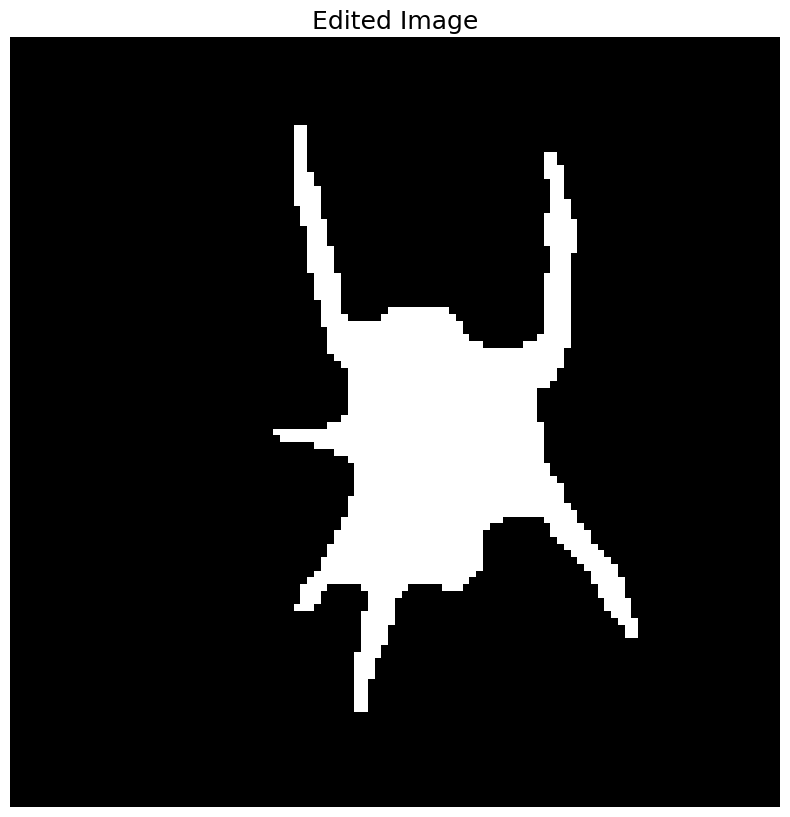

In [364]:
edited = process_spider(crop)
plt.figure(figsize=(10,10))
plt.imshow(edited, cmap = 'gray')
plt.title(f"Edited Image", fontsize=18)
plt.axis('off')
plt.show()  

In [373]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
# from sklearn.cluster import DBSCAN

# def count_spider_legs(image, show_image=False, exclude_centerband_px=5):
#     # Find contours and select the largest one (spider body + legs)
#     contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     if not contours:
#         return 0

#     main_contour = max(contours, key=cv2.contourArea)

#     # Get centroid of the contour
#     M = cv2.moments(main_contour)
#     if M["m00"] == 0:
#         return 0
#     cx, cy = int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])
#     center = np.array([cx, cy])

#     # Convert contour to polar coordinates
#     angles = []
#     radii = []
#     points = []

#     for pt in main_contour:
#         x, y = pt[0]
#         vec = np.array([x, y]) - center
#         angle = np.arctan2(vec[1], vec[0])
#         radius = np.linalg.norm(vec)
#         angles.append(angle)
#         radii.append(radius)
#         points.append((x, y))

#     angles = np.array(angles)
#     radii = np.array(radii)
#     points = np.array(points)

#     # Sort points by angle
#     sort_idx = np.argsort(angles)
#     angles = angles[sort_idx]
#     radii = radii[sort_idx]
#     points = points[sort_idx]

#     # Find radius peaks (you can tune distance and prominence here)
#     peaks, _ = find_peaks(radii,distance=5, prominence=3) #init - 5, 3
#     peak_angles = angles[peaks]
#     peak_radii = radii[peaks]
#     peak_points = points[peaks]

#     # Exclude points near vertical centerline
#     filtered_angles = []
#     filtered_radii = []
#     filtered_points = []
#     for angle, radius, pt in zip(peak_angles, peak_radii, peak_points):
#         if abs(pt[0] - cx) > exclude_centerband_px:
#             filtered_angles.append(angle)
#             filtered_radii.append(radius)
#             filtered_points.append(pt)

#     filtered_angles = np.array(filtered_angles)
#     filtered_radii = np.array(filtered_radii)
#     filtered_points = np.array(filtered_points)

#     # Cluster by angle to merge very close peaks
#     # Normalize angles to [0, 2pi)
#     angles_norm = (filtered_angles + 2 * np.pi) % (2 * np.pi)
#     angles_reshaped = angles_norm.reshape(-1, 1)

#     # Use DBSCAN with eps ~5 degrees in radians (~0.087 rad)
#     clusterer = DBSCAN(eps=np.deg2rad(6), min_samples=1)
#     labels = clusterer.fit_predict(angles_reshaped)

#     cluster_centers = []
#     cluster_radii = []
#     cluster_points = []

#     for label in np.unique(labels):
#         idxs = np.where(labels == label)[0]
#         # Select the peak with largest radius in cluster (most likely leg tip)
#         best_idx = idxs[np.argmax(filtered_radii[idxs])]
#         cluster_centers.append(filtered_angles[best_idx])
#         cluster_radii.append(filtered_radii[best_idx])
#         cluster_points.append(filtered_points[best_idx])

#     cluster_centers = np.array(cluster_centers)
#     cluster_radii = np.array(cluster_radii)
#     cluster_points = np.array(cluster_points)

#     # Sort clusters by descending radius (farthest first)
#     idx_sort_radius = np.argsort(-cluster_radii)
#     peak_angles_sorted = cluster_centers[idx_sort_radius]
#     peak_radii_sorted = cluster_radii[idx_sort_radius]
#     peak_points_sorted = cluster_points[idx_sort_radius]

#     # Simplified angular suppression to remove remaining very close points
#     def angular_suppression(peak_angles, peak_radii, peak_points, min_angle_rad):
#         selected = []
#         for angle_i, radius_i, point_i in zip(peak_angles, peak_radii, peak_points):
#             conflict = False
#             for angle_j, _, _ in selected:
#                 angle_diff = abs(angle_i - angle_j)
#                 angle_diff = min(angle_diff, 2*np.pi - angle_diff)
#                 if angle_diff < min_angle_rad:
#                     conflict = True
#                     break
#             if not conflict:
#                 selected.append((angle_i, radius_i, point_i))
#         return selected

#     min_angle_deg = 20
#     selected = angular_suppression(peak_angles_sorted, peak_radii_sorted, peak_points_sorted, np.deg2rad(min_angle_deg))
#     while len(selected) > 7 and min_angle_deg < 60:
#         min_angle_deg += 2
#         selected = angular_suppression(peak_angles_sorted, peak_radii_sorted, peak_points_sorted, np.deg2rad(min_angle_deg))

#     # Visualization
#     if show_image:
#         result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
#         cv2.circle(result, (cx, cy), 5, (0, 255, 0), -1)  # Center dot
#         for _, _, pt in selected:
#             cv2.circle(result, tuple(pt), 3, (0, 255, 255), -1)  # Leg tips
#         plt.imshow(result)
#         plt.axis("off")
#         plt.title(f"Detected legs: {len(selected)}")
#         plt.show()

#     return len(selected), print(peaks)
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.cluster import DBSCAN

def count_spider_legs_debug(image, show_image=False, exclude_centerband_px=2):
    print("=== SPIDER LEG DETECTION DEBUG ===")
    
    # More aggressive preprocessing to extend short legs
    # First, dilate to thicken legs
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated = cv2.dilate(image, kernel1, iterations=2)
    
    # Then use opening to separate merged parts
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel2)
    
    # Final dilation to extend leg tips
    kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
    enhanced = cv2.dilate(opened, kernel3, iterations=1)
    
    # Find contours and select the largest one (spider body + legs)
    contours, _ = cv2.findContours(enhanced, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        print("No contours found!")
        return 0

    main_contour = max(contours, key=cv2.contourArea)
    print(f"Main contour has {len(main_contour)} points")

    # Get centroid of the contour
    M = cv2.moments(main_contour)
    if M["m00"] == 0:
        print("Contour has zero area!")
        return 0
    cx, cy = int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])
    center = np.array([cx, cy])
    print(f"Centroid: ({cx}, {cy})")

    # Convert contour to polar coordinates
    angles = []
    radii = []
    points = []

    for pt in main_contour:
        x, y = pt[0]
        vec = np.array([x, y]) - center
        angle = np.arctan2(vec[1], vec[0])
        radius = np.linalg.norm(vec)
        angles.append(angle)
        radii.append(radius)
        points.append((x, y))

    angles = np.array(angles)
    radii = np.array(radii)
    points = np.array(points)

    # Sort points by angle
    sort_idx = np.argsort(angles)
    angles = angles[sort_idx]
    radii = radii[sort_idx]
    points = points[sort_idx]

    print(f"Max radius: {np.max(radii):.1f}, Min radius: {np.min(radii):.1f}")
    print(f"Radius std dev: {np.std(radii):.1f}")

    # Find radius peaks - much more sensitive for short legs
    peaks, properties = find_peaks(radii, distance=2, prominence=0.8, height=np.mean(radii))
    peak_angles = angles[peaks]
    peak_radii = radii[peaks]
    peak_points = points[peaks]
    
    print(f"\n--- STEP 1: Initial peak detection ---")
    print(f"Found {len(peaks)} initial peaks")
    for i, (angle, radius, pt) in enumerate(zip(peak_angles, peak_radii, peak_points)):
        print(f"  Peak {i}: angle={angle:.2f} rad ({np.degrees(angle):.1f}°), "
              f"radius={radius:.1f}, point=({pt[0]}, {pt[1]})")

    # Show radius profile plot for debugging
    if show_image:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(np.degrees(angles), radii, 'b-', alpha=0.7)
        plt.plot(np.degrees(angles[peaks]), radii[peaks], 'ro', markersize=8)
        plt.xlabel('Angle (degrees)')
        plt.ylabel('Radius')
        plt.title(f'Radius Profile ({len(peaks)} peaks found)')
        plt.grid(True)
        
        # Show image with all initial peaks
        plt.subplot(1, 2, 2)
        result = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
        cv2.circle(result, (cx, cy), 5, (0, 255, 0), -1)  # Center dot
        for i, pt in enumerate(peak_points):
            cv2.circle(result, tuple(pt), 3, (255, 0, 0), -1)  # All peaks in blue
            cv2.putText(result, str(i), (pt[0]+5, pt[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        plt.imshow(result)
        plt.axis("off")
        plt.title(f"All {len(peaks)} initial peaks")
        plt.tight_layout()
        plt.show()

    # Exclude points near vertical centerline
    print(f"\n--- STEP 2: Centerband filtering (exclude_centerband_px={exclude_centerband_px}) ---")
    filtered_angles = []
    filtered_radii = []
    filtered_points = []
    excluded_count = 0
    
    for i, (angle, radius, pt) in enumerate(zip(peak_angles, peak_radii, peak_points)):
        distance_from_center_x = abs(pt[0] - cx)
        if distance_from_center_x > exclude_centerband_px:
            filtered_angles.append(angle)
            filtered_radii.append(radius)
            filtered_points.append(pt)
            print(f"  Peak {i}: KEPT (x_dist={distance_from_center_x:.1f})")
        else:
            excluded_count += 1
            print(f"  Peak {i}: EXCLUDED by centerband (x_dist={distance_from_center_x:.1f})")

    print(f"After centerband filtering: {len(filtered_angles)} peaks remaining, {excluded_count} excluded")

    if len(filtered_angles) == 0:
        print("No peaks remaining after centerband filtering!")
        return 0

    filtered_angles = np.array(filtered_angles)
    filtered_radii = np.array(filtered_radii)
    filtered_points = np.array(filtered_points)

    # Cluster by angle to merge very close peaks
    print(f"\n--- STEP 3: Angle clustering ---")
    angles_norm = (filtered_angles + 2 * np.pi) % (2 * np.pi)
    angles_reshaped = angles_norm.reshape(-1, 1)

    clusterer = DBSCAN(eps=np.deg2rad(6), min_samples=1)
    labels = clusterer.fit_predict(angles_reshaped)

    cluster_centers = []
    cluster_radii = []
    cluster_points = []

    for label in np.unique(labels):
        idxs = np.where(labels == label)[0]
        best_idx = idxs[np.argmax(filtered_radii[idxs])]
        cluster_centers.append(filtered_angles[best_idx])
        cluster_radii.append(filtered_radii[best_idx])
        cluster_points.append(filtered_points[best_idx])
        
        if len(idxs) > 1:
            print(f"  Cluster {label}: merged {len(idxs)} peaks, kept peak with radius {filtered_radii[best_idx]:.1f}")
        else:
            print(f"  Cluster {label}: single peak with radius {filtered_radii[best_idx]:.1f}")

    cluster_centers = np.array(cluster_centers)
    cluster_radii = np.array(cluster_radii)
    cluster_points = np.array(cluster_points)

    print(f"After clustering: {len(cluster_centers)} clusters")

    # Sort clusters by descending radius
    idx_sort_radius = np.argsort(-cluster_radii)
    peak_angles_sorted = cluster_centers[idx_sort_radius]
    peak_radii_sorted = cluster_radii[idx_sort_radius]
    peak_points_sorted = cluster_points[idx_sort_radius]

    # Angular suppression
    print(f"\n--- STEP 4: Angular suppression ---")
    def angular_suppression_debug(peak_angles, peak_radii, peak_points, min_angle_rad):
        selected = []
        for i, (angle_i, radius_i, point_i) in enumerate(zip(peak_angles, peak_radii, peak_points)):
            conflict = False
            conflict_with = -1
            for j, (angle_j, _, _) in enumerate(selected):
                angle_diff = abs(angle_i - angle_j)
                angle_diff = min(angle_diff, 2*np.pi - angle_diff)
                if angle_diff < min_angle_rad:
                    conflict = True
                    conflict_with = j
                    break
            if not conflict:
                selected.append((angle_i, radius_i, point_i))
                print(f"  Peak {i}: KEPT (angle={np.degrees(angle_i):.1f}°, radius={radius_i:.1f})")
            else:
                print(f"  Peak {i}: REJECTED (angle={np.degrees(angle_i):.1f}°, conflicts with peak {conflict_with})")
        return selected

    min_angle_deg = 20
    selected = angular_suppression_debug(peak_angles_sorted, peak_radii_sorted, peak_points_sorted, np.deg2rad(min_angle_deg))
    
    while len(selected) > 7 and min_angle_deg < 60:
        min_angle_deg += 2
        print(f"Too many peaks ({len(selected)}), increasing min_angle to {min_angle_deg}°")
        selected = angular_suppression_debug(peak_angles_sorted, peak_radii_sorted, peak_points_sorted, np.deg2rad(min_angle_deg))

    print(f"\nFINAL RESULT: {len(selected)} legs detected")

    # Final visualization
    if show_image:
        plt.figure(figsize=(8, 6))
        result = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
        cv2.circle(result, (cx, cy), 5, (0, 255, 0), -1)  # Center dot
        for i, (_, _, pt) in enumerate(selected):
            cv2.circle(result, tuple(pt), 4, (0, 255, 255), -1)  # Final legs in yellow
            cv2.putText(result, str(i+1), (pt[0]+5, pt[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        plt.imshow(result)
        plt.axis("off")
        plt.title(f"Final result: {len(selected)} legs detected")
        plt.show()

    return len(selected)

# Keep original function for backwards compatibility
def count_spider_legs(image, show_image=False, exclude_centerband_px=2):
    return count_spider_legs_debug(image, show_image, exclude_centerband_px)

=== SPIDER LEG DETECTION DEBUG ===
Main contour has 339 points
Centroid: (64, 58)
Max radius: 52.3, Min radius: 16.6
Radius std dev: 9.5

--- STEP 1: Initial peak detection ---
Found 53 initial peaks
  Peak 0: angle=-2.24 rad (-128.4°), radius=37.0, point=(41, 29)
  Peak 1: angle=-2.21 rad (-126.9°), radius=40.0, point=(40, 26)
  Peak 2: angle=-2.08 rad (-119.2°), radius=49.2, point=(40, 15)
  Peak 3: angle=-2.06 rad (-118.1°), radius=51.0, point=(40, 13)
  Peak 4: angle=-2.05 rad (-117.6°), radius=51.9, point=(40, 12)
  Peak 5: angle=-2.03 rad (-116.1°), radius=52.3, point=(41, 11)
  Peak 6: angle=-2.01 rad (-115.1°), radius=51.9, point=(42, 11)
  Peak 7: angle=-1.99 rad (-114.1°), radius=51.5, point=(43, 11)
  Peak 8: angle=-1.98 rad (-113.6°), radius=34.9, point=(50, 26)
  Peak 9: angle=-1.97 rad (-113.1°), radius=51.1, point=(44, 11)
  Peak 10: angle=-1.96 rad (-112.3°), radius=42.2, point=(48, 19)
  Peak 11: angle=-1.95 rad (-112.0°), radius=50.7, point=(45, 11)
  Peak 12: angle=-

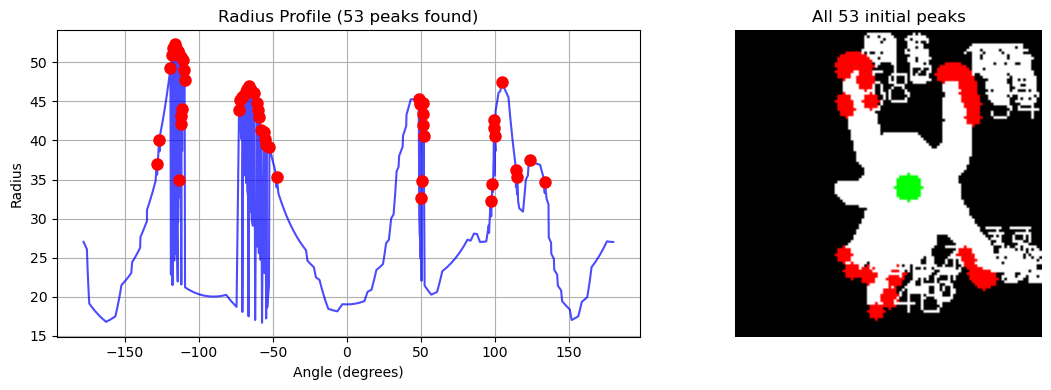


--- STEP 2: Centerband filtering (exclude_centerband_px=2) ---
  Peak 0: KEPT (x_dist=23.0)
  Peak 1: KEPT (x_dist=24.0)
  Peak 2: KEPT (x_dist=24.0)
  Peak 3: KEPT (x_dist=24.0)
  Peak 4: KEPT (x_dist=24.0)
  Peak 5: KEPT (x_dist=23.0)
  Peak 6: KEPT (x_dist=22.0)
  Peak 7: KEPT (x_dist=21.0)
  Peak 8: KEPT (x_dist=14.0)
  Peak 9: KEPT (x_dist=20.0)
  Peak 10: KEPT (x_dist=16.0)
  Peak 11: KEPT (x_dist=19.0)
  Peak 12: KEPT (x_dist=16.0)
  Peak 13: KEPT (x_dist=16.0)
  Peak 14: KEPT (x_dist=18.0)
  Peak 15: KEPT (x_dist=17.0)
  Peak 16: KEPT (x_dist=16.0)
  Peak 17: KEPT (x_dist=13.0)
  Peak 18: KEPT (x_dist=14.0)
  Peak 19: KEPT (x_dist=15.0)
  Peak 20: KEPT (x_dist=16.0)
  Peak 21: KEPT (x_dist=17.0)
  Peak 22: KEPT (x_dist=18.0)
  Peak 23: KEPT (x_dist=19.0)
  Peak 24: KEPT (x_dist=20.0)
  Peak 25: KEPT (x_dist=21.0)
  Peak 26: KEPT (x_dist=22.0)
  Peak 27: KEPT (x_dist=22.0)
  Peak 28: KEPT (x_dist=22.0)
  Peak 29: KEPT (x_dist=22.0)
  Peak 30: KEPT (x_dist=23.0)
  Peak 31: KEPT 

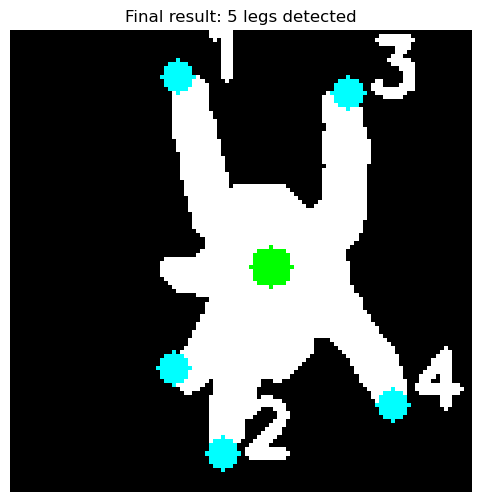

5


In [374]:
print(count_spider_legs_debug(image = edited, show_image = True))

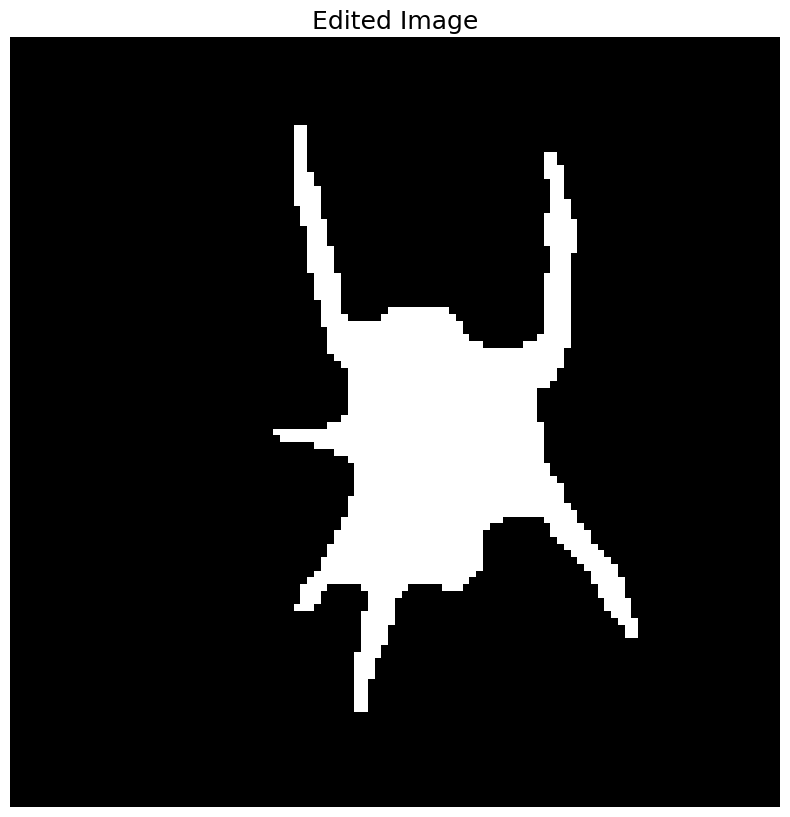

In [250]:
plt.figure(figsize=(10,10))
plt.imshow(edited, cmap = 'gray')
plt.title(f"Edited Image", fontsize=18)
plt.axis('off')
plt.show()  

In [74]:
testIm = Image.fromarray(rgb_thresh)
Pil = testIm.convert("RGB")

In [82]:
import torch
import numpy as np
from PIL import Image, ImageDraw
import cv2
from scipy.ndimage import center_of_mass

def find_spider_with_dino_and_sam(
    full_image: np.ndarray,
    reference_mask: np.ndarray,
    dino_model,
    dino_processor,
    sam_predictor,
    box_threshold: float = 0.4,
    text_threshold: float = 0.3,
    sam_iou_threshold: float = 0.5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) DINO inference
    pil = Image.fromarray(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
    inputs = dino_processor(images=pil, text=[["spider"]], return_tensors="pt").to(device)
    with torch.no_grad():
        out = dino_model(**inputs)
    res = dino_processor.post_process_grounded_object_detection(
        out, inputs.input_ids,
        box_threshold=box_threshold,
        text_threshold=text_threshold,
        target_sizes=[pil.size[::-1]]
    )[0]

    # 2) Decide crop region
    if len(res["boxes"]) > 0:
        # take highest‐score box
        scores = res["scores"].cpu().numpy()
        boxes = res["boxes"].cpu().numpy().astype(int)
        idx = np.argmax(scores)
        x0, y0, x1, y1 = boxes[idx]
        crop_img = full_image[y0:y1, x0:x1]
        crop_origin = (x0, y0)
        box = (x0, y0, x1, y1)
    else:
        # fallback: full image
        crop_img = full_image
        crop_origin = (0, 0)
        box = None

    # 3) Compute center‐of‐mass point from reference mask
    # (convert reference mask coords into the crop’s coordinate frame)
    ys, xs = np.where(reference_mask > 0)
    if len(ys) == 0:
        raise ValueError("Reference mask empty; cannot prompt SAM.")
    com_y, com_x = center_of_mass(reference_mask)
    # shift to crop frame
    com_x_crop = com_x - crop_origin[0]
    com_y_crop = com_y - crop_origin[1]
    point = np.array([[com_x_crop, com_y_crop]])
    label = np.array([1])  # foreground

    # 4) SAM inference on crop using point prompt
    sam_predictor.set_image(crop_img)
    masks, scores, _ = sam_predictor.predict(
        point_coords=point,
        point_labels=label,
        multimask_output=False
    )
    sam_mask_crop = masks[0]

    # 5) (Optional) check IoU between DINO box and SAM mask bbox if box exists
    if box is not None:
        # compute SAM mask bbox
        ys2, xs2 = np.where(sam_mask_crop)
        ymin2, xmin2 = ys2.min(), xs2.min()
        ymax2, xmax2 = ys2.max(), xs2.max()
        # convert to full‐image coords
        sam_box = np.array([xmin2, ymin2, xmax2, ymax2]) + np.array(crop_origin*2)
        # IoU test
        def _iou(a, b):
            xA, yA = max(a[0], b[0]), max(a[1], b[1])
            xB, yB = min(a[2], b[2]), min(a[3], b[3])
            inter = max(0, xB-xA)*max(0, yB-yA)
            area = (a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - inter
            return inter/area if area>0 else 0
        dino_box = np.array(box)
        if _iou(dino_box, sam_box) < sam_iou_threshold:
            # if low agreement, you could fallback to DINO box mask or union; here we stick with SAM
            pass

    # 6) Build full‐image mask from crop mask
    full_mask = np.zeros(full_image.shape[:2], dtype=np.uint8)
    x0, y0 = crop_origin
    h, w = sam_mask_crop.shape
    full_mask[y0:y0+h, x0:x0+w] = (sam_mask_crop>0).astype(np.uint8)

    return full_mask, box



In [345]:
example = cv2.imread(r'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_25 - 1.jpg')
# Load model & processor (change model_id as needed)
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
model_id = "IDEA-Research/grounding-dino-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
example = process_image(example)
EXMask, bbox = find_spider_with_dino_and_sam(
    full_image = example,
    reference_mask = reference,
    dino_model = model,      
    dino_processor = processor, 
    sam_predictor = predictor,)

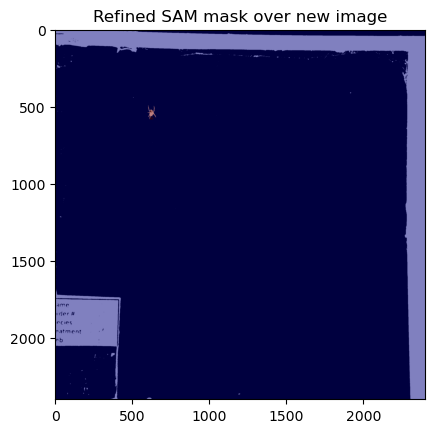

In [346]:
plt.imshow(cv2.cvtColor(example, cv2.COLOR_BGR2RGB))
plt.imshow(EXMask, alpha=0.5, cmap = 'jet')
plt.title("Refined SAM mask over new image")
plt.show()

In [146]:
crop2, cropMask2 = crop_to_mask_circle(example, EXMask)

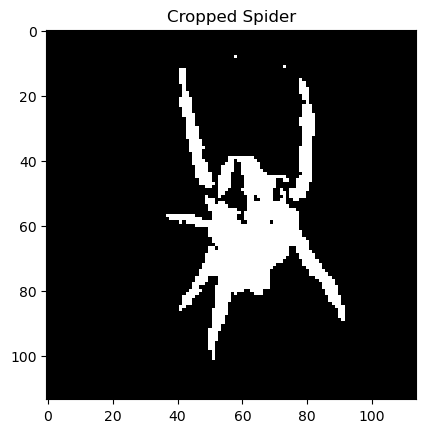

In [191]:
plt.imshow(cv2.cvtColor(crop2, cv2.COLOR_BGR2RGB))
plt.title("Cropped Spider")
plt.show()

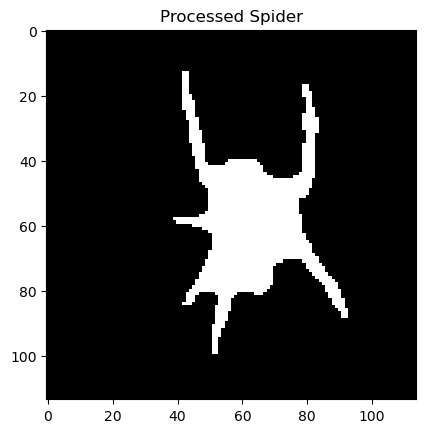

In [347]:
processed = process_spider(crop2)
plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
plt.title("Processed Spider")
plt.show()

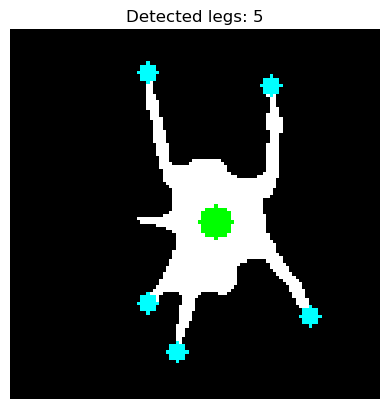

5


In [348]:
print(count_spider_legs(image = processed, show_image = True))


In [131]:
directory = r"C:\Users\adamain\Downloads\cropped_frames"
image_paths = []
for filename in os.listdir(directory):
    if filename.lower().endswith(".jpg"):
        image_paths.append(os.path.join(directory, filename))
#We already have the mask for this one, it's the reference image/mask        
image_paths.remove(r"C:\Users\adamain\Downloads\cropped_frames\cropped_EX.jpg")
print(image_paths)


['C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_19 - 1.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_19 - 2.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_19 - 3.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_19 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_25 - 1.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_25 - 2.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_25 - 3.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_25 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - 1.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - 2.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - 3.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - 4.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - 5.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - C.jpg', 'C:\\Users\\adamain\\Downloads\\c

In [142]:
dummy = [image_paths[0], image_paths[4]]

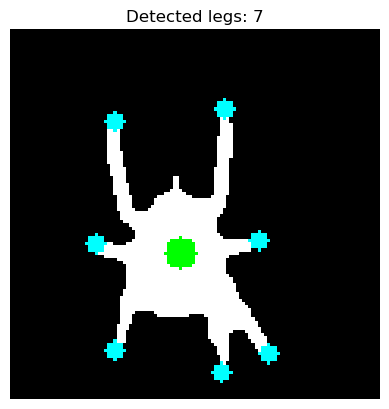

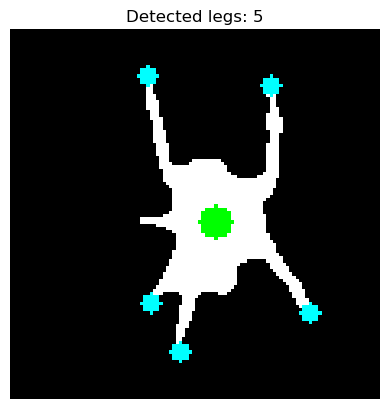

[7, 5]


In [181]:
leg_numbers = []

for image in dummy:
    frame = cv2.imread(image)
    thresholded = process_image(frame)
    mask, bbox = find_spider_with_dino_and_sam(full_image = thresholded, reference_mask = reference, dino_model = model, dino_processor = processor, sam_predictor = predictor,)
    crop, cropMask = crop_to_mask_circle(thresholded, mask)
    processed = process_spider(crop)
    leg_numbers.append(count_spider_legs(processed, show_image=True))

print(leg_numbers)